In [61]:
from itertools import compress

import matplotlib.pyplot as plt
import numpy as np

import mne

For some reason, we get double plots all the time

HbR (deoxyhaemoglobin) is less oxynated haemoglobin (HbO)

In [62]:
#Downloading and loading dataset
fnirs_data_folder = mne.datasets.fnirs_motor.data_path()
fnirs_cw_amplitude_dir = fnirs_data_folder / "Participant-1"
raw_intensity = mne.io.read_raw_nirx(fnirs_cw_amplitude_dir, verbose=True)
raw_intensity.load_data()

Loading /Users/bumblebee/mne_data/MNE-fNIRS-motor-data/Participant-1
Reading 0 ... 23238  =      0.000 ...  2974.464 secs...


<RawNIRX | Participant-1, 56 x 23239 (2974.5 s), ~10.0 MB, data loaded>

In [63]:
# Annotating and removing unnecessary trigger codes

raw_intensity.annotations.set_durations(5)
raw_intensity.annotations.rename(
    {"1.0": "Control", "2.0": "Tapping/Left", "3.0": "Tapping/Right"}
)
unwanted = np.nonzero(raw_intensity.annotations.description == "15.0")
raw_intensity.annotations.delete(unwanted)

In [64]:
# # Visualizing the nodes on the brain (not working)

# subjects_dir = mne.datasets.sample.data_path() / "subjects"

# brain = mne.viz.Brain(
#     "fsaverage", subjects_dir=subjects_dir, background="w", cortex="0.5"
# )
# brain.add_sensors(
#     raw_intensity.info,
#     trans="fsaverage",
#     fnirs=["channels", "pairs", "sources", "detectors"],
# )
# brain.show_view(azimuth=20, elevation=60, distance=400)

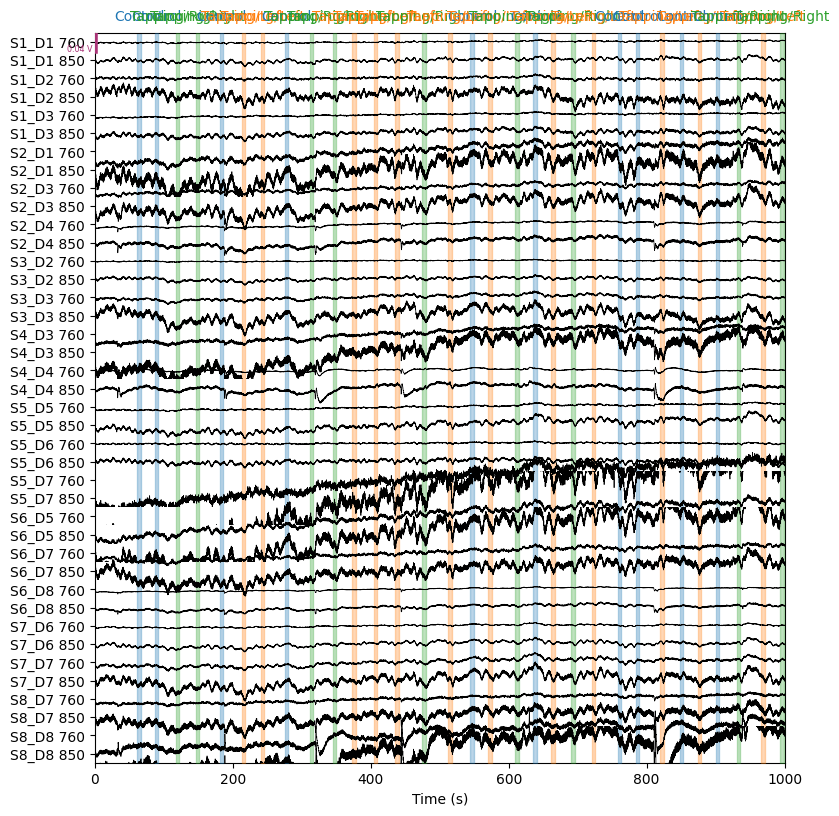

In [65]:
# Removin all "short channels" that are too close together to detect neural responses. Then visualizing the data

picks = mne.pick_types(raw_intensity.info, meg=False, fnirs=True)
dists = mne.preprocessing.nirs.source_detector_distances(
    raw_intensity.info, picks=picks
)
raw_intensity.pick(picks[dists > 0.01])
raw_intensity.plot(
    n_channels=len(raw_intensity.ch_names), duration=1000, show_scrollbars=False
)
plt.close('all')

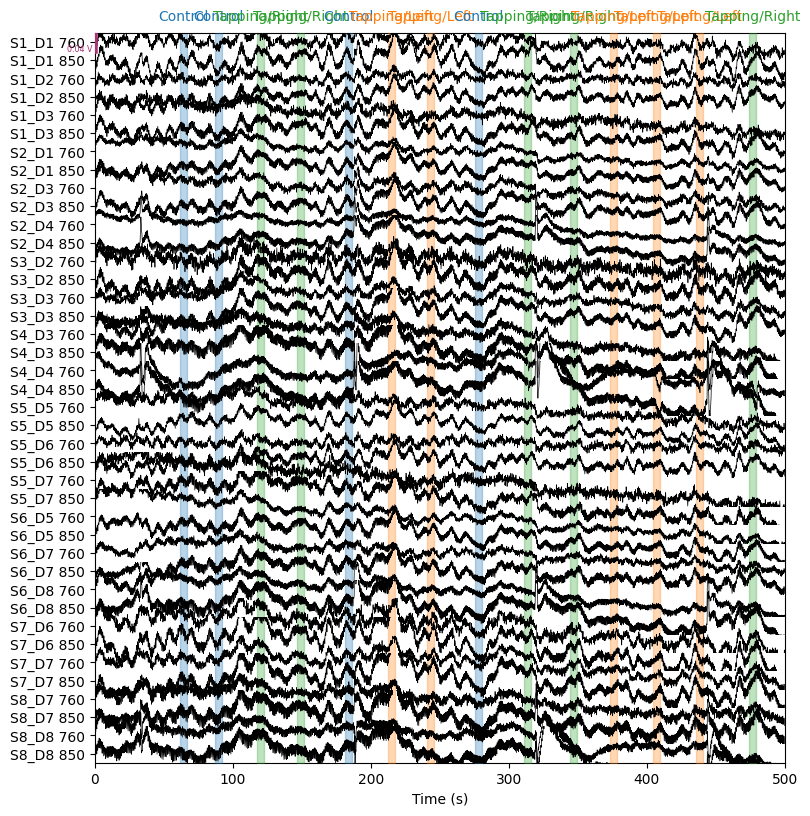

In [66]:
# Converting raw intensity to optical density. Raw intensity is the raw data from the fNIRS device
# nd optical density is the log of the ratio of light intensities between the detectors and sources.
# This is done to remove the effects of light scattering and absorption in the scalp and skull.

raw_od = mne.preprocessing.nirs.optical_density(raw_intensity)
raw_od.plot(n_channels=len(raw_od.ch_names), duration=500, show_scrollbars=False)
plt.close('all')

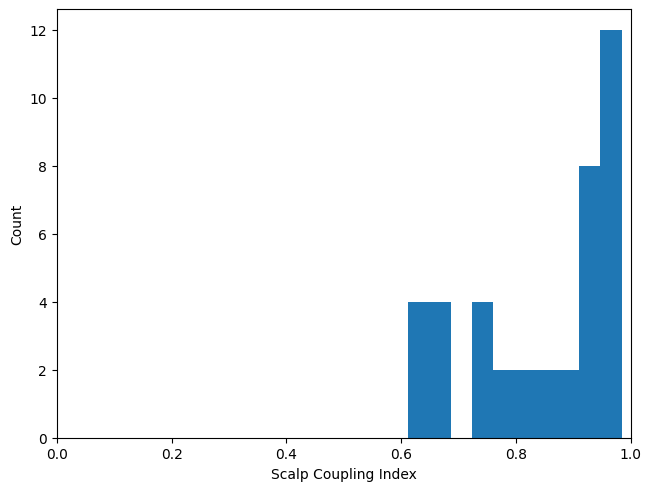

In [67]:
# Checking the quality of the coupling between the scalp and the optodes. Here is it clean data so we don't remove bad channels

plt.close('all')
sci = mne.preprocessing.nirs.scalp_coupling_index(raw_od)
fig, ax = plt.subplots(layout="constrained")
ax.hist(sci)
ax.set(xlabel="Scalp Coupling Index", ylabel="Count", xlim=[0, 1])
plt.show()

# (All channels with SCI < 0.5 are considered bad)
raw_od.info["bads"] = list(compress(raw_od.ch_names, sci < 0.5))

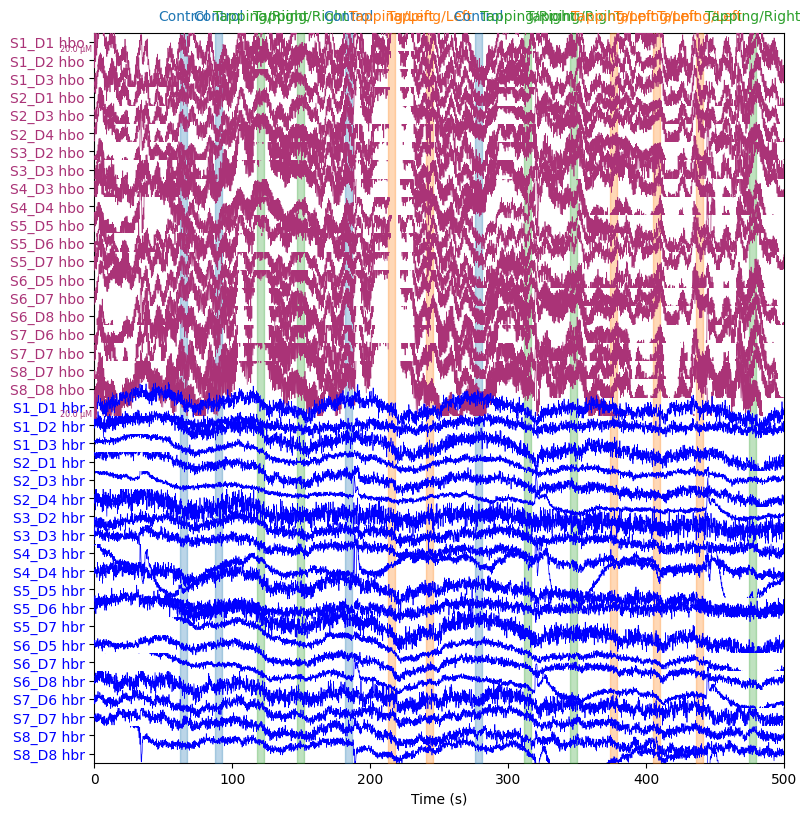

In [68]:
# Converting from optical density to haemoglobin concentration. This is done using the Beer-Lambert Law
# Done to get quantitative measure of relative changes in blood oxygenation

raw_haemo = mne.preprocessing.nirs.beer_lambert_law(raw_od, ppf=0.1)
raw_haemo.plot(n_channels=len(raw_haemo.ch_names), duration=500, show_scrollbars=False)
plt.close('all')

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1291 samples (165.248 s)

Effective window size : 262.144 (s)
Plotting power spectral density (dB=True).
Effective window size : 262.144 (s)
Plotting power spectral density (dB=True).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)
/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


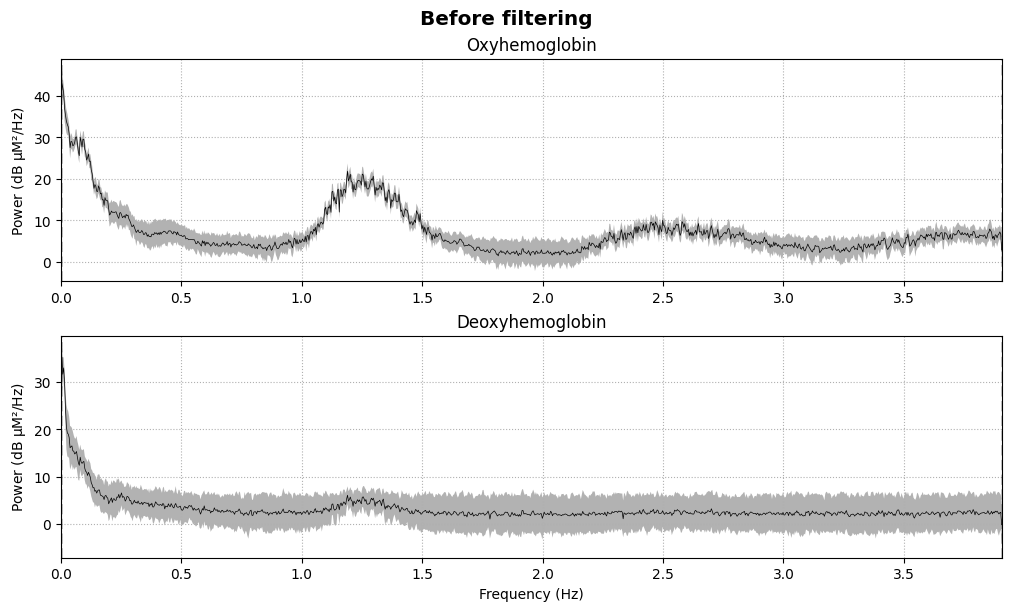

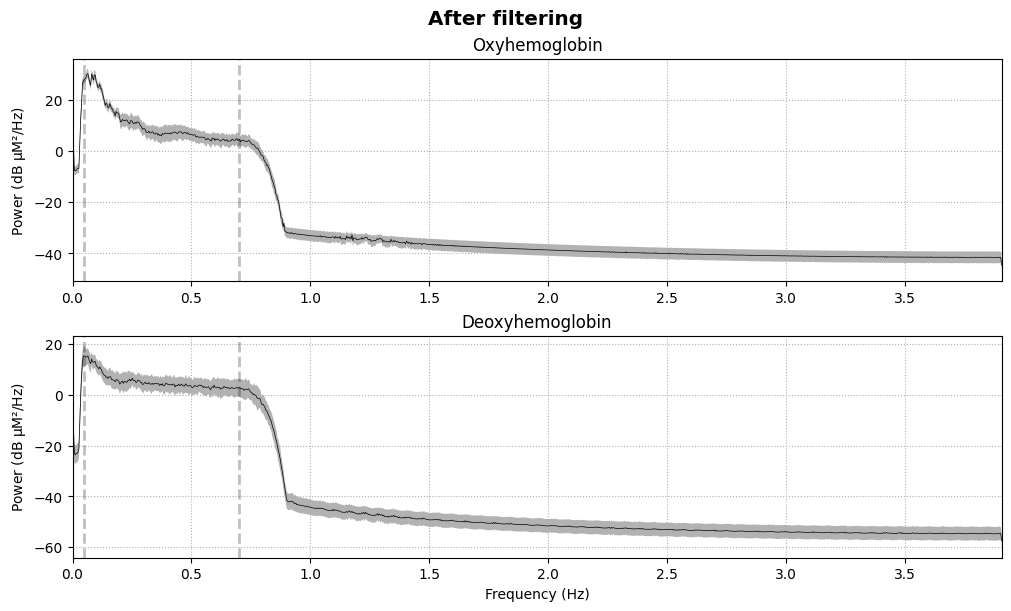

In [69]:
# Applying band pass filter to remove heartrate and slow drifts
# RERUN THE CODE ABOVE TO SEE THE EFFECT OF THE FILTER
plt.close('all')

raw_haemo_unfiltered = raw_haemo.copy()
raw_haemo.filter(0.05, 0.7, h_trans_bandwidth=0.2, l_trans_bandwidth=0.02)
for when, _raw in dict(Before=raw_haemo_unfiltered, After=raw_haemo).items():
    fig = _raw.compute_psd().plot(
        average=True, amplitude=False, picks="data", exclude="bads"
    )
    fig.suptitle(f"{when} filtering", weight="bold", size="x-large")

plt.show()

Used Annotations descriptions: ['Control', 'Tapping/Left', 'Tapping/Right']


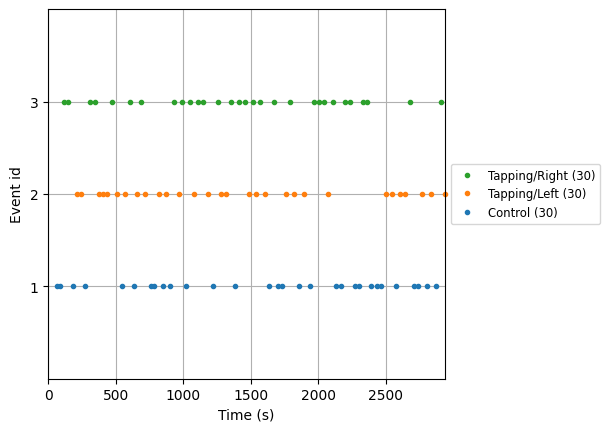

In [70]:
# Visualizing events
events, event_dict = mne.events_from_annotations(raw_haemo)
fig = mne.viz.plot_events(events, event_id=event_dict, sfreq=raw_haemo.info["sfreq"])

Not setting metadata
90 matching events found
Setting baseline interval to [-4.992, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 90 events and 157 original time points ...
    Rejecting  epoch based on HBO : ['S4_D4 hbo']
    Rejecting  epoch based on HBO : ['S4_D4 hbo', 'S8_D8 hbo']
    Rejecting  epoch based on HBO : ['S4_D4 hbo']
    Rejecting  epoch based on HBO : ['S4_D4 hbo', 'S8_D8 hbo']
    Rejecting  epoch based on HBO : ['S1_D1 hbo', 'S3_D3 hbo', 'S4_D4 hbo', 'S7_D6 hbo', 'S7_D7 hbo', 'S8_D8 hbo']
    Rejecting  epoch based on HBO : ['S4_D4 hbo', 'S6_D8 hbo', 'S8_D8 hbo']
6 bad epochs dropped


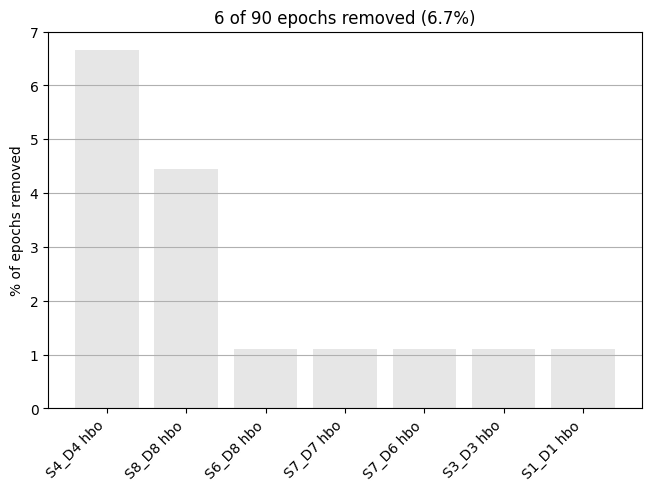

In [71]:
# Defining range of epochs (events from above), rejection criteria, baseline correction, and extracting epochs
reject_criteria = dict(hbo=80e-6) # any signal exceeding 80e-6 is considered too noisy
tmin, tmax = -5, 15

epochs = mne.Epochs(
    raw_haemo,
    events,
    event_id=event_dict,
    tmin=tmin,
    tmax=tmax,
    reject=reject_criteria,
    reject_by_annotation=True,
    proj=True,
    baseline=(None, 0), # normalizing based on the average of the start of the epoch until time 0
    preload=True,
    detrend=None,
    verbose=True,
)
epochs.plot_drop_log()
plt.close('all')

Not setting metadata
55 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
55 matching events found
No baseline correction applied
0 projection items activated
combining channels using "mean"
combining channels using "mean"


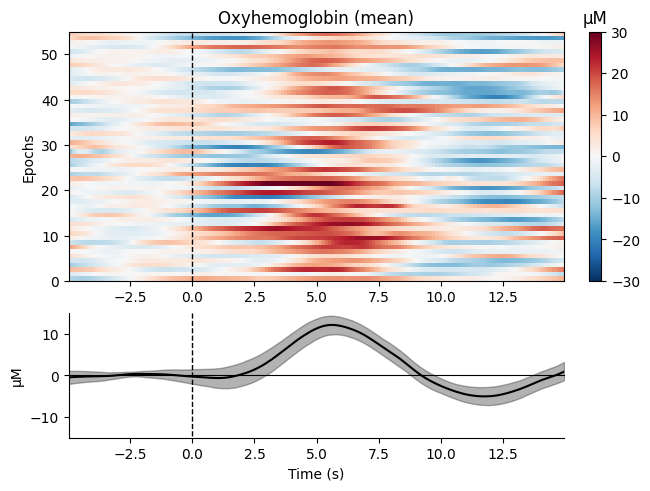

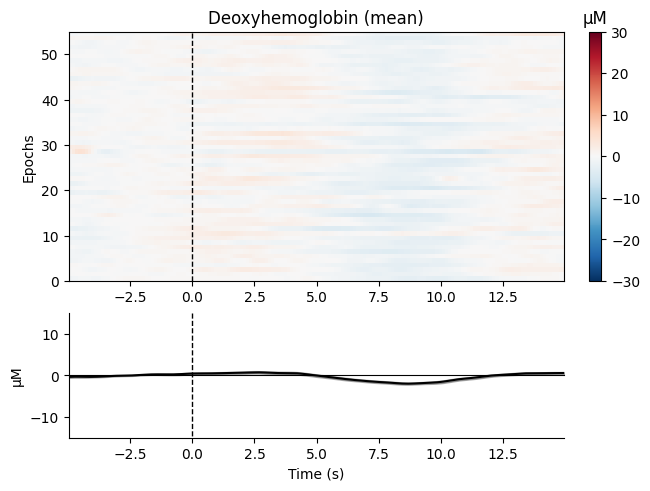

[<Figure size 640x480 with 3 Axes>, <Figure size 640x480 with 3 Axes>]

In [72]:
# Visualize heamodynamic response to tapping
# Seeing expected peak of HbO around 6 sec and dip in HbR slightly delayed relative to HbO peak

epochs["Tapping"].plot_image(
    combine="mean",
    vmin=-30,
    vmax=30,
    ts_args=dict(ylim=dict(hbo=[-15, 15], hbr=[-15, 15])),
)

In [73]:
# Select 5 random epochs
indices = np.random.choice(len(epochs), size=5, replace=False)
for idx in indices:
    # Get the data of the epoch: shape (1, n_channels, n_samples)
    data = epochs[idx].get_data()
    n_samples = data.shape[2]
    # Duration of the epoch in seconds: number of samples divided by the sampling frequency
    duration = n_samples / epochs.info["sfreq"]
    print(f"Epoch {idx}: {n_samples} samples, {duration:.2f} seconds")

Epoch 61: 157 samples, 20.10 seconds
Epoch 43: 157 samples, 20.10 seconds
Epoch 80: 157 samples, 20.10 seconds
Epoch 83: 157 samples, 20.10 seconds
Epoch 72: 157 samples, 20.10 seconds


Not setting metadata
29 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
29 matching events found
No baseline correction applied
0 projection items activated
combining channels using "mean"
combining channels using "mean"


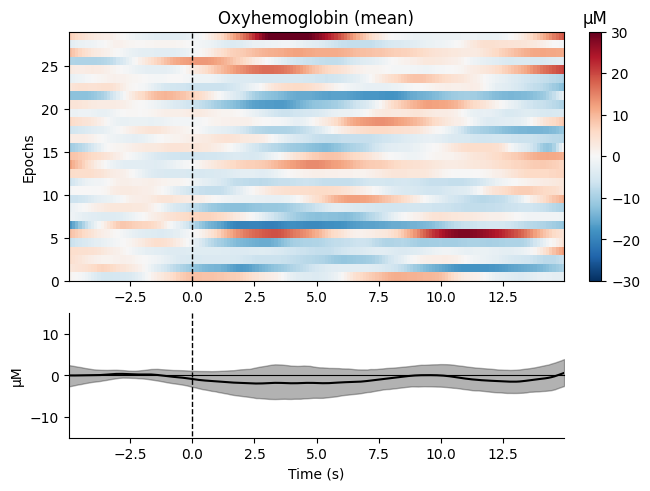

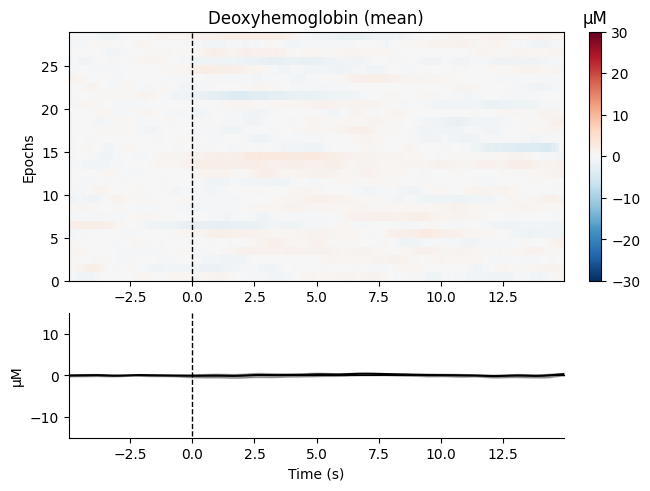

[<Figure size 640x480 with 3 Axes>, <Figure size 640x480 with 3 Axes>]

In [74]:
# Epochs for control
epochs["Control"].plot_image(
    combine="mean",
    vmin=-30,
    vmax=30,
    ts_args=dict(ylim=dict(hbo=[-15, 15], hbr=[-15, 15])),
)

In [ ]:
# # Viewing consistency of response across all selected pairs
# # (Doable since all nodes are over the motor cortex)
# fig_control = epochs["Control"].average().plot_image(clim=clims)
# for ax in fig_control.axes:
#     ax.set_title("Control: " + ax.get_title())

# fig_tapping = epochs["Tapping"].average().plot_image(clim=clims)
# for ax in fig_tapping.axes:
#     ax.set_title("Tapping: " + ax.get_title())

NameError: name 'clims' is not defined

## Most common plot

In [ ]:
# Plotting HbO and HbR on the same figure to illustrate relation between the two signals
# (HbR decreases shortly after HbO increases)

evoked_dict = {
    "Tapping/HbO": epochs["Tapping"].average(picks="hbo"),
    "Tapping/HbR": epochs["Tapping"].average(picks="hbr"),
    "Control/HbO": epochs["Control"].average(picks="hbo"),
    "Control/HbR": epochs["Control"].average(picks="hbr"),
}

# Rename channels until the encoding of frequency in ch_name is fixed
for condition in evoked_dict:
    evoked_dict[condition].rename_channels(lambda x: x[:-4])

color_dict = dict(HbO="#AA3377", HbR="b")
styles_dict = dict(Control=dict(linestyle="dashed"))

mne.viz.plot_compare_evokeds(
    evoked_dict, combine="mean", ci=0.95, colors=color_dict, styles=styles_dict
)

combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


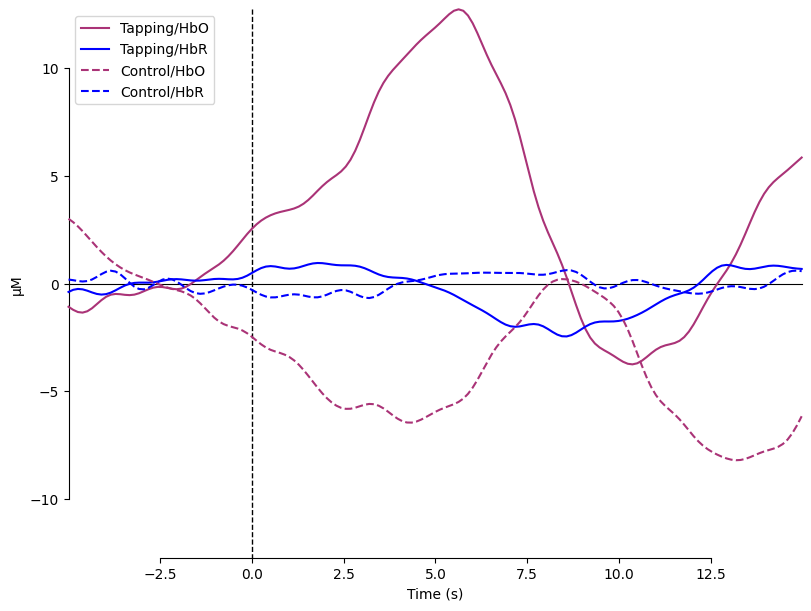

[<Figure size 800x600 with 1 Axes>]

In [ ]:
# Plotting HbO and HbR on the same figure using all odd epochs to illustrate relation between the two signals
# (HbR decreases shortly after HbO increases)

# USING ALL ODD EPOCHS
evoked_dict = {
    "Tapping/HbO": epochs["Tapping"][:3].average(picks="hbo"),
    "Tapping/HbR": epochs["Tapping"][:3].average(picks="hbr"),
    "Control/HbO": epochs["Control"][:3].average(picks="hbo"),
    "Control/HbR": epochs["Control"][:3].average(picks="hbr"),
}

# Rename channels until the encoding of frequency in ch_name is fixed
for condition in evoked_dict:
    evoked_dict[condition].rename_channels(lambda x: x[:-4])

color_dict = dict(HbO="#AA3377", HbR="b")
styles_dict = dict(Control=dict(linestyle="dashed"))

mne.viz.plot_compare_evokeds(
    evoked_dict, combine="mean", ci=0.95, colors=color_dict, styles=styles_dict
)

combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


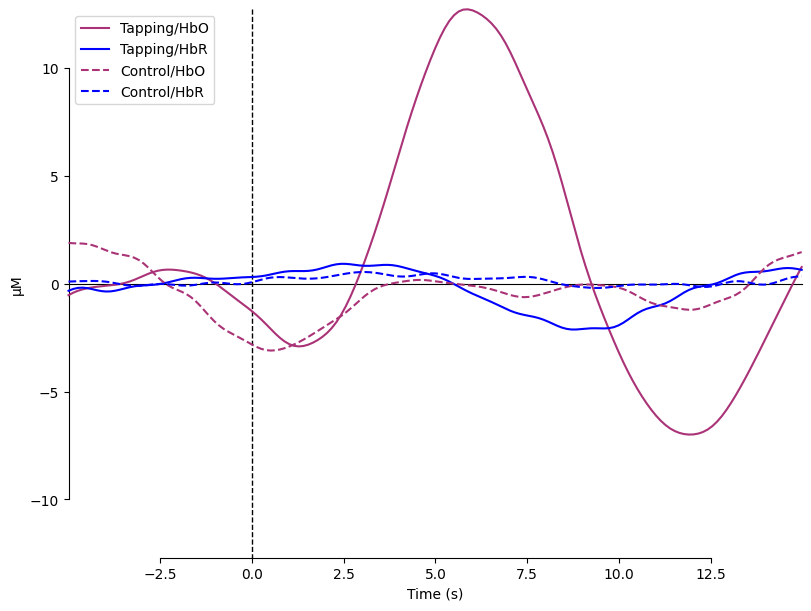

[<Figure size 800x600 with 1 Axes>]

In [ ]:
# Plotting HbO and HbR on the same figure using all even epochs to illustrate relation between the two signals
# (HbR decreases shortly after HbO increases)

# USING ALL EVEN EPOCHS
evoked_dict = {
    "Tapping/HbO": epochs["Tapping"][::2].average(picks="hbo"),
    "Tapping/HbR": epochs["Tapping"][::2].average(picks="hbr"),
    "Control/HbO": epochs["Control"][::2].average(picks="hbo"),
    "Control/HbR": epochs["Control"][::2].average(picks="hbr"),
}

# Rename channels until the encoding of frequency in ch_name is fixed
for condition in evoked_dict:
    evoked_dict[condition].rename_channels(lambda x: x[:-4])

mne.viz.plot_compare_evokeds(
    evoked_dict, combine="mean", ci=0.95, colors=color_dict, styles=styles_dict
)


No projector specified for this dataset. Please consider the method self.add_proj.


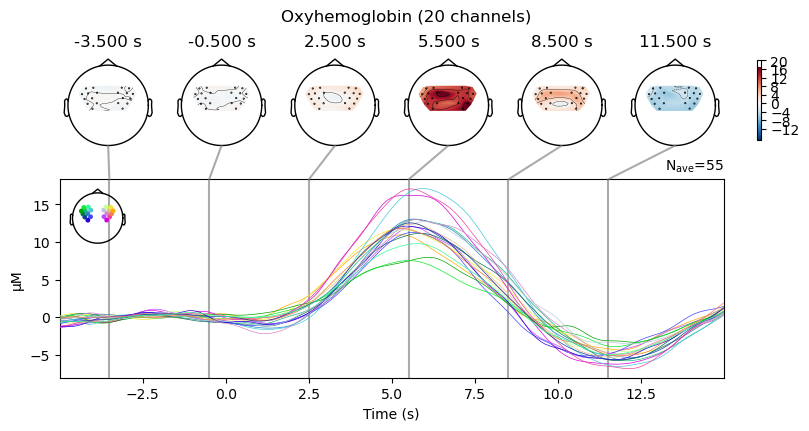

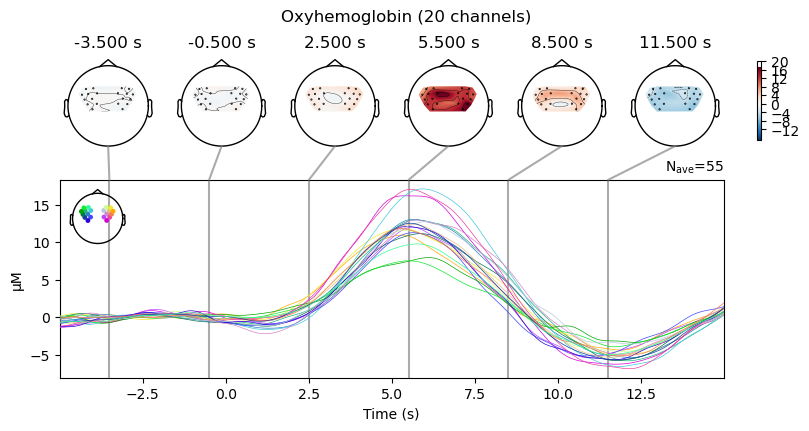

In [ ]:
# Viewing topographic maps of the response
# (Topographic maps show the spatial distribution of the response)

times = np.arange(-3.5, 13.2, 3.0)
topomap_args = dict(extrapolate="local")
epochs["Tapping"].average(picks="hbo").plot_joint(
    times=times, topomap_args=topomap_args
)
plt.close('all')

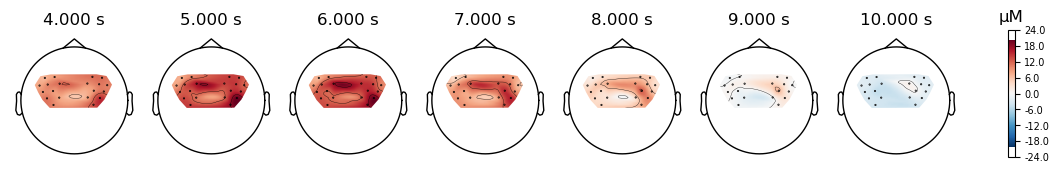

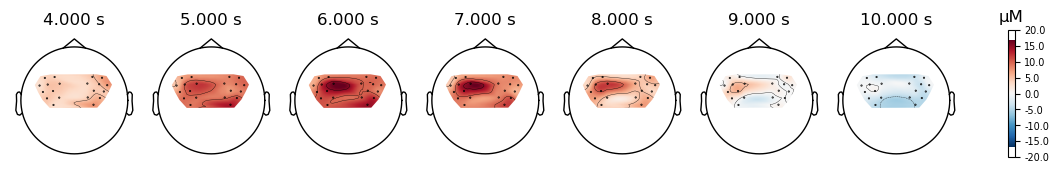

In [ ]:
# Comparing the topographic maps of tapping left and right
# We see that the response is stronger on the contralateral side (opposite of the effect)
times = np.arange(4.0, 11.0, 1.0)
epochs["Tapping/Left"].average(picks="hbo").plot_topomap(times=times, **topomap_args)
epochs["Tapping/Right"].average(picks="hbo").plot_topomap(times=times, **topomap_args)
plt.close('all')

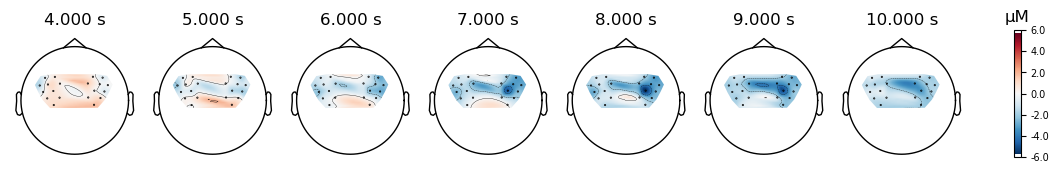

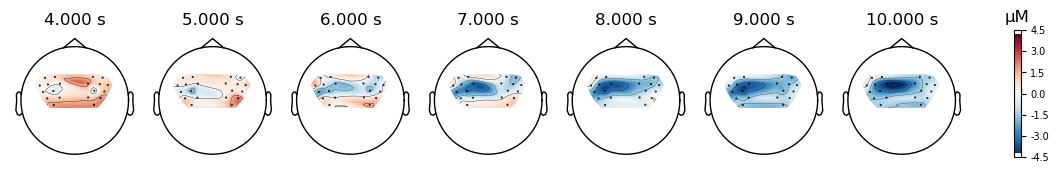

In [ ]:
# Viewing topographic maps of HbR
# Again seeing stronger response on the contralateral side
epochs["Tapping/Left"].average(picks="hbr").plot_topomap(times=times, **topomap_args)
epochs["Tapping/Right"].average(picks="hbr").plot_topomap(times=times, **topomap_args)
plt.close('all')

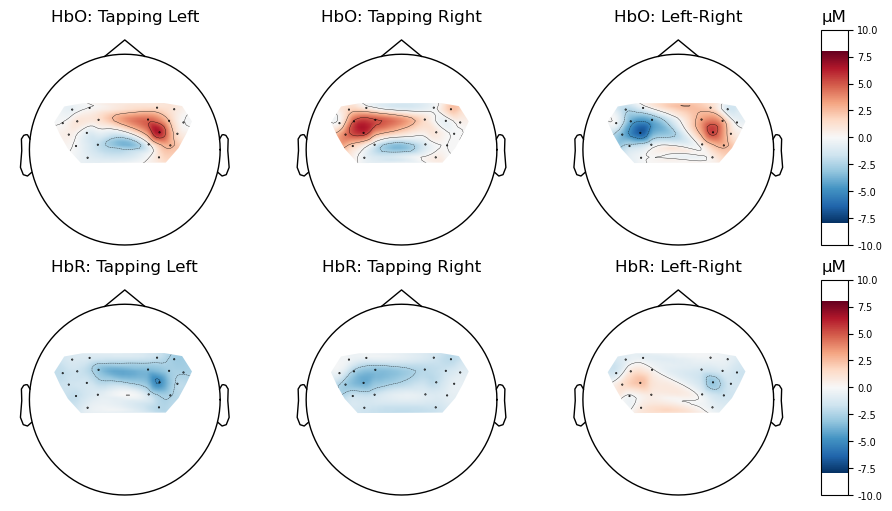

In [ ]:
# Comparison of a single time point for two conditions
# left-right difference is the difference between the two conditions

fig, axes = plt.subplots(
    nrows=2,
    ncols=4,
    figsize=(9, 5),
    gridspec_kw=dict(width_ratios=[1, 1, 1, 0.1]),
    layout="constrained",
)
vlim = (-8, 8)
ts = 9.0

evoked_left = epochs["Tapping/Left"].average()
evoked_right = epochs["Tapping/Right"].average()

evoked_left.plot_topomap(
    ch_type="hbo", times=ts, axes=axes[0, 0], vlim=vlim, colorbar=False, **topomap_args, show=False
)
evoked_left.plot_topomap(
    ch_type="hbr", times=ts, axes=axes[1, 0], vlim=vlim, colorbar=False, **topomap_args, show=False
)
evoked_right.plot_topomap(
    ch_type="hbo", times=ts, axes=axes[0, 1], vlim=vlim, colorbar=False, **topomap_args, show=False
)
evoked_right.plot_topomap(
    ch_type="hbr", times=ts, axes=axes[1, 1], vlim=vlim, colorbar=False, **topomap_args, show=False
)

evoked_diff = mne.combine_evoked([evoked_left, evoked_right], weights=[1, -1])

evoked_diff.plot_topomap(
    ch_type="hbo", times=ts, axes=axes[0, 2:], vlim=vlim, colorbar=True, **topomap_args, show=False
)
evoked_diff.plot_topomap(
    ch_type="hbr", times=ts, axes=axes[1, 2:], vlim=vlim, colorbar=True, **topomap_args, show=False
)

for column, condition in enumerate(["Tapping Left", "Tapping Right", "Left-Right"]):
    for row, chroma in enumerate(["HbO", "HbR"]):
        axes[row, column].set_title(f"{chroma}: {condition}")
plt.show()
plt.close('all')

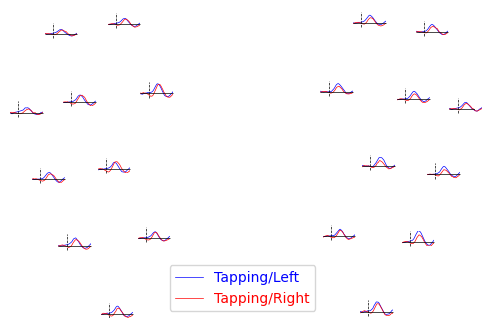

In [ ]:
# One time-series plot per channel laid out in the topographic map
# visualizing blue and green HbO response on the left and right side of the brain respectively

fig, ax = plt.subplots(figsize=(6, 4))

evokeds = [
    epochs["Left"].average(picks="hbo"),
    epochs["Right"].average(picks="hbo")
]
colors = ["b", "r"]

mne.viz.plot_evoked_topo(
    evokeds,
    color=colors,
    axes=ax,
    legend=True,
)
plt.show()
